

### Imports and path to Dataset

In [3]:


# my Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, preprocessing, backend
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


from keras.layers import Input, BatchNormalization, Activation, Concatenate, AveragePooling2D
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from google.colab import drive


In [4]:
# Connecting Google Drive to the CodeFile in Colab
drive.mount('/content/drive')

# setting the Path for the dataset
train_path = '/content/drive/My Drive/chest_xray/train'
test_path = '/content/drive/My Drive/chest_xray/test'

Mounted at /content/drive


### Functons:
This part contains all the functions that are used in this code file with there respective doc strings

In [5]:

def barPlotForDataset(path, name):
  """
  Function to draw the bar Plot
  """

  # List of subdirectories
  classes = ['NORMAL', 'PNEUMONIA']

  # Initialize lists to store the number of images per class
  num_images_per_class = []

  # Iterate through each class directory
  for class_name in classes:
      # Count the number of files in the class directory
      class_path = os.path.join(path, class_name)
      num_images = len(os.listdir(class_path))
      num_images_per_class.append(num_images)

  print(num_images_per_class)



  plt.figure(figsize=(6, 5))
  plt.bar(classes, num_images_per_class, color='skyblue')
  plt.xlabel('Classes')
  plt.ylabel('Number of Images')
  plt.title('Number of Images in the ' + name +' Folder')

  #Adding labels to the bars
  for i in range(len(classes)):
      plt.text(i, num_images_per_class[i], str(num_images_per_class[i]), ha='center', va='bottom')
  plt.show()


In [6]:
def draw_line_plot():
  """
  Function to plot the Loss and Accuracy

  """
    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x = history.epoch, y = history.history['loss'])
    sns.lineplot(x = history.epoch, y = history.history['val_loss'])
    ax.set_title('Learning Curve (Loss)')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim(0, 0.5)
    ax.legend(['train', 'val'], loc='best')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
    sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
    ax.set_title('Learning Curve (Accuracy)')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylim(0.80, 1.0)
    ax.legend(['train', 'val'], loc='best')
    plt.show()

In [7]:
performance_metrics = {}



def eval_model_2(model, heatmap_color = 'Reds', model_name='undefiend'):
  """
  Function to evaluate the model with the test data and
  store the Accuracy, Recall, Precision and F1 Score in the performance metrics variable

  Args: model: Model, heatmap_color: color of the heatmap produced, model_name: Name of the model

  """

  performance_metrics[model_name] = []
  # Reset the test data generator
  ds_test.reset()

  # Make predictions on the test dataset
  predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)

  # Convert predicted probabilities to binary predictions (0 or 1)
  pred_labels = np.where(predictions > 0.5, 1, 0)

  # Map class labels to numerical values for true labels
  num_label = {'Normal': 0, 'Pneumonia': 1}
  Y_test = df_test_balanced['class'].map(num_label).astype(int)

  # Calculate precision of the model
  precision = precision_score(Y_test, pred_labels)
  performance_metrics[model_name].append(precision)

  # # Calculate accuracy of the model
  # accuracy = accuracy_score(Y_test, pred_labels)

  # Calculate recall of the model
  recall = recall_score(Y_test, pred_labels)
  performance_metrics[model_name].append(recall)

  # Calculate F1 score of the model
  f1 = f1_score(Y_test, pred_labels)
  performance_metrics[model_name].append(f1)

  score_1 = model.evaluate(ds_val, steps = len(val_df)/BATCH_SIZE, verbose = 0)
  score_2 = model.evaluate(ds_test, steps = len(df_test_balanced), verbose = 0)
  performance_metrics[model_name].append(score_1[1])
    # Print the calculated metrics
  print('Val loss:', score_1[0])
  print('Val accuracy:', score_1[1])
  print('Test loss:', score_2[0])
  print('Test accuracy:', score_2[1])
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1 Score:", f1)

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(Y_test, pred_labels)
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap= heatmap_color,
              xticklabels=['Normal', 'Pneumonia'],
              yticklabels=['Normal', 'Pneumonia'])
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()


In [8]:
# Function for model training

def train_model(model):

  history = model.fit(ds_train,
          batch_size = 32, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/32),
          validation_steps=(len(val_df)/32));
  return history

### Functions for all Model Architectures

In [9]:
# Funciton for defining Custom CNN Model Architecture

def custom_CNN_model():
    """
    Implementation of a custom CNN model for binary image classification.

    Returns:
        Keras Model instance representing the custom CNN model.
    """

    # Define the input tensor with specified shape
    inputs = Input(shape=(224, 224, 3))

    # Convolutional layer blocks
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the feature maps to feed into a dense layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='custom_cnn_model')

    return model


### Data Visualization

[1341, 3893]


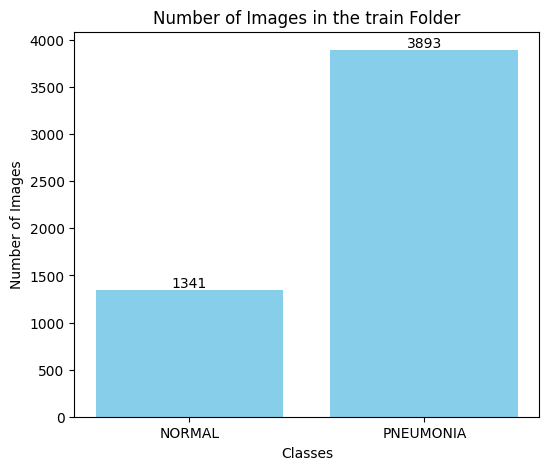

[234, 390]


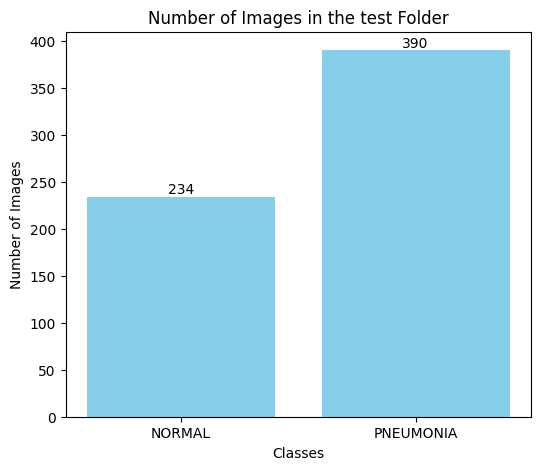

In [11]:
barPlotForDataset(train_path, "train")
barPlotForDataset(test_path, "test")

### Preparing The dataset


In [3]:

train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")

# Create DataFrame for training data
df_train_normal = pd.DataFrame({'class': 'Normal', 'image': train_normal})
df_train_pneumonia = pd.DataFrame({'class': 'Pneumonia', 'image': train_pneumonia})

# Calculate the number of samples in each class
num_pneumonia = len(df_train_pneumonia)
num_normal = len(df_train_normal)

print(num_pneumonia, num_normal)

# Oversample the Normal class to match the number of Pneumonia samples
df_train_normal_oversampled = df_train_normal.sample(n=num_pneumonia, replace=True, random_state=42)

# Concatenate oversampled Normal class and original Pneumonia class
df_train_balanced = pd.concat([df_train_normal_oversampled, df_train_pneumonia])

# Shuffle the DataFrame rows
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Shuffle the test data as well
df_test_normal = pd.DataFrame({'class': 'Normal', 'image': test_normal})
df_test_pneumonia = pd.DataFrame({'class': 'Pneumonia', 'image': test_pneumonia})
df_test_balanced = pd.concat([df_test_normal, df_test_pneumonia])

df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



# Now df_train_balanced and df_test_balanced have balanced classes

NameError: name 'glob' is not defined

In [ ]:
# Spliting the train dataset into train and validation
train_df, val_df = train_test_split(df_train_balanced, test_size = 0.20, random_state = 42, stratify = df_train_balanced['class'])




### Preprocessing

In [16]:
# Defining the preprocessing that needs to be applied

BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1./255
                                  )

In [17]:
#  setting up train and test dataset into batchs of 32 and in greyscale

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             batch_size = BATCH_SIZE,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = BATCH_SIZE,
                                            seed = 42)

ds_test = val_datagen.flow_from_dataframe(df_test_balanced,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 6228 validated image filenames belonging to 2 classes.
Found 1558 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### Callbacks

In [18]:
#Setting callbakcs

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,

)

plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

### Custom CNN

In [69]:
keras.backend.clear_session()
# model = get_model()
model = custom_CNN_model()
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')
model.summary()

Model: "custom_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)  

In [70]:

history = train_model(model)

Epoch 1/50
194/194 [==============================] - 181s 920ms/step - loss: 0.4992 - binary_accuracy: 0.7747 - val_loss: 0.3099 - val_binary_accuracy: 0.8806 - lr: 3.0000e-05
Epoch 2/50
194/194 [==============================] - 174s 895ms/step - loss: 0.3022 - binary_accuracy: 0.8876 - val_loss: 0.2685 - val_binary_accuracy: 0.8851 - lr: 3.0000e-05
Epoch 3/50
194/194 [==============================] - 173s 890ms/step - loss: 0.2616 - binary_accuracy: 0.9059 - val_loss: 0.2289 - val_binary_accuracy: 0.9031 - lr: 3.0000e-05
Epoch 4/50
194/194 [==============================] - 170s 874ms/step - loss: 0.2389 - binary_accuracy: 0.9130 - val_loss: 0.1859 - val_binary_accuracy: 0.9288 - lr: 3.0000e-05
Epoch 5/50
194/194 [==============================] - 174s 893ms/step - loss: 0.2291 - binary_accuracy: 0.9175 - val_loss: 0.2056 - val_binary_accuracy: 0.9198 - lr: 3.0000e-05
Epoch 6/50
194/194 [==============================] - 174s 894ms/step - loss: 0.2249 - binary_accuracy: 0.9175 - va

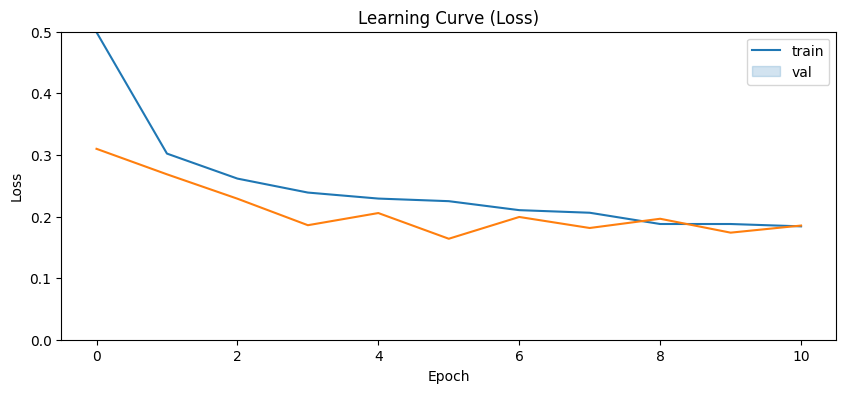

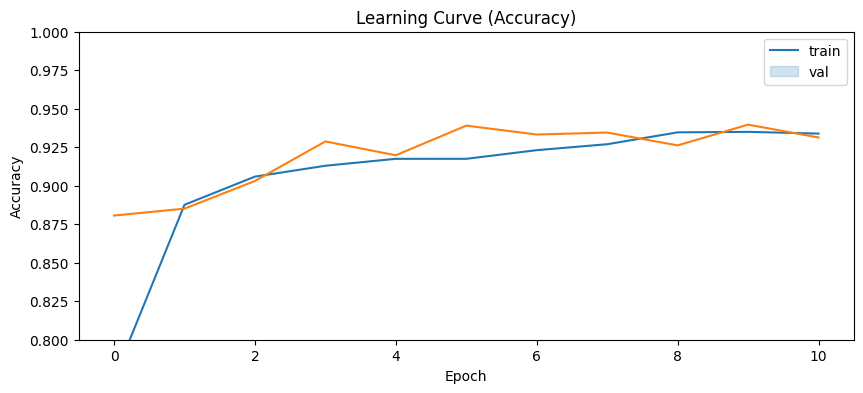

In [71]:

draw_line_plot()

Val loss: 0.16392579674720764
Val accuracy: 0.9390243887901306
Test loss: 0.33945271372795105
Test accuracy: 0.8830128312110901
Recall: 0.9641025641025641
Precision: 0.864367816091954
F1 Score: 0.9115151515151515


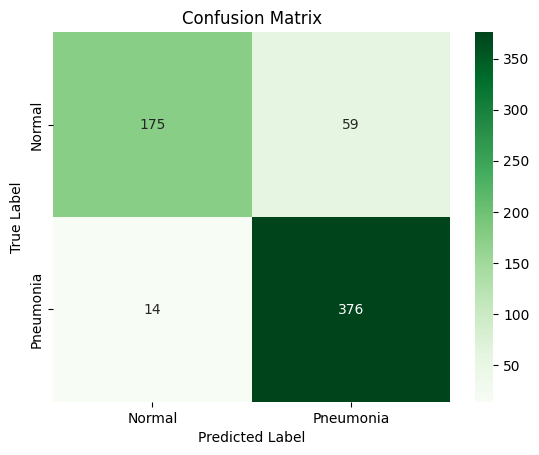

In [76]:
eval_model_2(model,'Greens','custom_CNN')

###Transfer Learning with Densenet model


In [ ]:
keras.backend.clear_session()

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

def build_densenet_model(input_shape=(224, 224, 3), num_classes=1):
    # Loading DenseNet121 pretrained on ImageNet without the top (fully connected) layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freezing the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom top layers for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    # Creating the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


input_shape = (224, 224, 3)  # Input shape of the images
num_classes = 1  # Binary classification (pneumonia detection)

# Building the DenseNet model for transfer learning
model = build_densenet_model(input_shape=input_shape, num_classes=num_classes)

# Compiling the model with appropriate loss and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Model summary
model.summary()

In [ ]:

history = train_model(model)

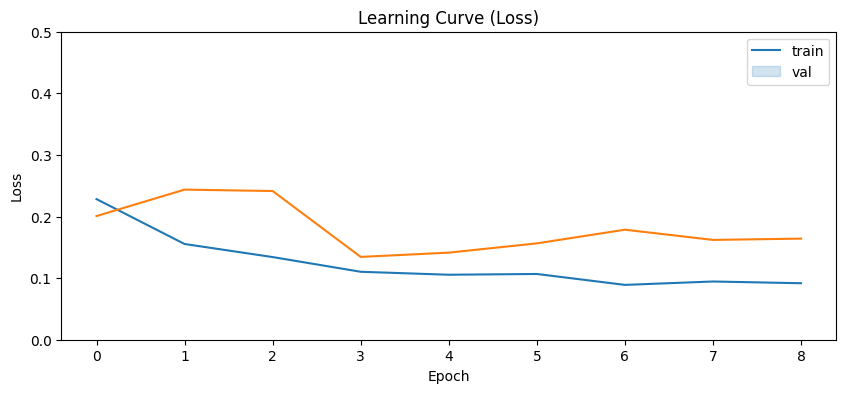

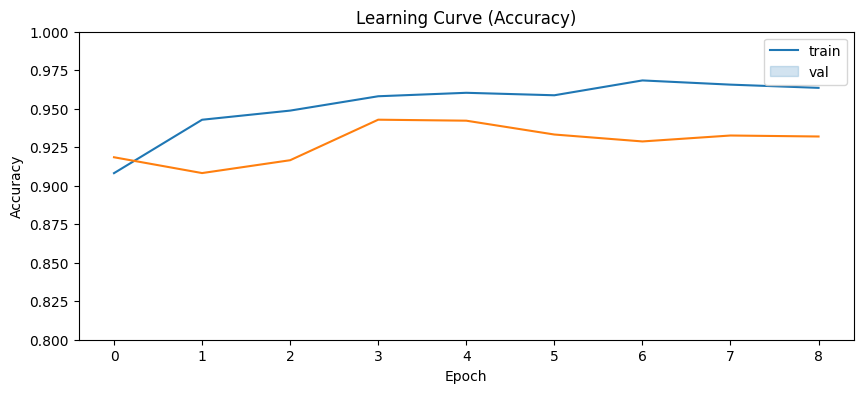

In [21]:
draw_line_plot()

In [ ]:
eval_model_2(model,'Reds','DenseNet')

### Transfer Learning with ResNet Model

In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(224, 224, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model


In [ ]:
keras.backend.clear_session()

model = get_pretrained()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model.summary()

In [ ]:
history = train_model(model)

In [ ]:
draw_line_plot()

In [ ]:
eval_model_2(model,'Blues','ResNet')

### ResNet Fine-Tuned

In [ ]:
base_model.trainable = True

# Freezing all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [ ]:
# Checking which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model.summary()

In [ ]:
history = model.fit(ds_train,
          batch_size = 32, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/32),
          validation_steps=(len(val_df)/32));

In [ ]:
draw_line_plot()

In [ ]:
eval_model_2(model, 'Blues','ResNet Fine-Tuned')

###Performance Metrics

In [91]:
print(performance_metrics)

{'custom_CNN': [0.864367816091954, 0.9641025641025641, 0.9115151515151515, 0.9390243887901306], 'DenseNet': [0.8175965665236051, 0.9769230769230769, 0.8901869158878505, 0.9621309638023376], 'ResNet': [0.8577878103837472, 0.9743589743589743, 0.9123649459783914, 0.9505776762962341], 'ResNet Fine-Tuned': [0.875, 0.9692307692307692, 0.9197080291970802, 0.9557124376296997]}
